In [3]:
import numpy as np
import pandas as pd
import seaborn as sns


# ML Workflow

A construção dos modelos de Machine Learning muitas vezes depende mais da qualidade dos dados e dos cuidados tomados contra **data leakage** do que das escolhas técnicas do cientista de dados. Hoje veremos um *workflow* padrão para a trabalhar com conjuntos de dados - garantindo que não exista leakage e que nosso conjunto de treinamento está limpo.

Além disso, devemos sempre lembrar que os modelos preditivos **existem para fazer previsões**! Um dos maiores problemas hoje em dia no campo de machine learning é a dificuldade em levar um modelo da fase de protótipo à produção. Vamos discutir ao longo da aula pontos sensíveis na implantação de um modelo e que como podemos evitar armadilhas.

In [4]:
tb_hotel = pd.read_csv("https://raw.githubusercontent.com/pedroteche-ih/79_PT_JUN2022/main/aulas/data/tb_hotel_aula.csv")
tb_hotel.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   is_cancelled             119390 non-null  int64  
 1   lead_time                119390 non-null  int64  
 2   country                  118902 non-null  object 
 3   company                  6797 non-null    float64
 4   children                 119386 non-null  float64
 5   adults                   119390 non-null  int64  
 6   meal                     119390 non-null  object 
 7   adr                      119390 non-null  float64
 8   reservation_status_date  119390 non-null  object 
 9   booking_changes          119390 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 9.1+ MB


In [5]:
tb_hotel.head()

,is_cancelled,lead_time,country,company,children,adults,meal,adr,reservation_status_date,booking_changes
0,0,342,PRT,NaN,0.0,2,BB,0.0,2015-07-01,3
1,0,737,PRT,NaN,0.0,2,BB,0.0,2015-07-01,4
2,0,7,GBR,NaN,0.0,1,BB,75.0,2015-07-02,0
3,0,13,GBR,NaN,0.0,1,BB,75.0,2015-07-02,0
4,0,14,GBR,NaN,0.0,2,BB,98.0,2015-07-03,0


## Evitando *leakage*

*Data leakage* é um erro extremamente comum no campo de ciência de dados. Em uma análise feita para um [artigo da revista Nature](https://www.nature.com/articles/d41586-022-02035-w), em um review de 340 artigos, 329 apresentavam **falhas em reprodutibilidade**. Outro estudo, conduzido na Universidade de Birmingham, apontou que menos de 5% dos artigos médicos utilizando Machine Learning se preocupavam com a possibilidade de implantação dos modelos em ambiente clínicos.

*Leakage* acontece quando não garantimos, na etapa de construção do modelo, que estamos operando dentro das mesmas condições que o modelo irá operar quando estiver em produção. Para garantir estas condições precisamos cumprir duas etapas:

1. **Limpeza de variáveis**: como conjuntos de dados utilizados na construção de modelos são sempre dados históricos, precisamos garantir que as variáveis que estamos utilizando estarão disponíveis do momento em que o modelo for utilizado para fazer previsões;
1. **Avaliação de Erro em conjunto Teste**: para modelos preditivos, precisamos avaliar o erro de previsão destes modelos em conjuntos de dados que não foram utilizados nas etapas de aprendizagem.

Na primeira etapa **precisamos descobrir e entender como o dado é produzido**: quais sistemas são utilizados, quais são os *fatos transacionais*, e, finalmente, quais as informações que estarão disponíveis no momento de predição. Além disso, precisamos **garantir** que as etapas de pré-processamento do modelo **funcionarão** sobre dados futuros!

Excluindo variáveis que não estarão disponíveis em sua forma histórica em dados presentes, a divisão test/train possibilita que avaliemos o modelo em todas as suas etapas: pré-processamento, aprendizagem e avaliação.

In [6]:
from sklearn.model_selection import train_test_split


In [7]:
X_var = ["lead_time", "country", "company", "children", "adults", "meal", "adr"]
y_var = "is_cancelled"
X = tb_hotel[X_var]
y = tb_hotel[y_var]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
X_test.head()

,lead_time,country,company,children,adults,meal,adr
68697,32,BRA,NaN,0.0,2,BB,190.00
55231,120,FRA,NaN,0.0,2,BB,127.80
103853,41,BRA,NaN,0.0,2,BB,70.00
51316,323,PRT,NaN,0.0,2,BB,70.00
95126,14,NLD,NaN,2.0,0,BB,138.05


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


## Tratando NAs

Para tratar de valores NA em um modelo de machine learning, não basta *exluir linhas*! Temos que lembrar que, em produção, os dados alimentados ao modelo poderão conter NAs. Precisamos criar mecânismos que **preencham** esses valores ou então desncosiderar as variáveis que podem conte-los.

In [16]:
X_train.isna().sum()

lead_time        0
country        357
company      84451
children         4
adults           0
meal             0
adr              0
dtype: int64

In [15]:
X_train.isna().sum() / X_train.shape[0]


lead_time    0.000000
country      0.003987
company      0.943144
children     0.000045
adults       0.000000
meal         0.000000
adr          0.000000
dtype: float64

### Tratativas Manuais

A melhor forma de tratar valores NA é compreendendo **porque eles existem** em uma dada variável. Se conhecemos as causas por trás destes valores, podemos criar tratativas diretas e específicas à cada variável.

In [18]:
X_train[X_train["company"].notna()]

,lead_time,country,company,children,adults,meal,adr
14061,0,PRT,16.0,0.0,2,BB,228.00
84183,99,PRT,67.0,0.0,1,BB,81.00
8757,364,GBR,223.0,0.0,2,BB,72.00
23805,3,PRT,154.0,0.0,1,BB,75.00
8134,334,GBR,223.0,0.0,2,BB,69.43
...,...,...,...,...,...,...,...
2953,36,DEU,281.0,0.0,1,BB,36.00
24744,61,PRT,169.0,0.0,1,BB,50.00
82181,99,PRT,67.0,0.0,2,BB,80.00
35521,60,PRT,307.0,0.0,2,BB,90.00


In [19]:
mask_na_company = X_train["company"].isna()

X_train.loc[mask_na_company, "is_company"] = 0
X_train.loc[~mask_na_company, "is_company"] = 1


### Imputando valores

Caso não seja possível elucidar porque certas variáveis contém NAs, podemos recorrer a **imputação de valores**. A imputação pode ser arriscada se os valores não foram gerados por erros de sistema, ou então se tem uma estrutura subjacente, portanto devemos utiliza-la apenas após estudar o processo de geração de dados e garantir que estes valores são:

1. Raros;
1. Causados por falhas no sistema;

In [22]:
X_train.isna().sum() / X_train.shape[0] * 100


lead_time      0.000000
country        0.398696
company       94.314400
children       0.004467
adults         0.000000
meal           0.000000
adr            0.000000
is_company     0.000000
dtype: float64

In [20]:
from sklearn.impute import SimpleImputer


In [24]:
X_train["country"].value_counts()

country
PRT    36427
GBR     9114
FRA     7792
ESP     6483
DEU     5484
       ...  
NIC        1
IMN        1
PYF        1
UMI        1
BFA        1
Name: count, Length: 164, dtype: int64

In [61]:
country_imputer = SimpleImputer(strategy="most_frequent")
country_imputer.fit(X_train[["country"]])


SimpleImputer(strategy='most_frequent')

In [39]:
country_imputer.transform(X_train[["country"]])

array([['PRT'],
       ['ITA'],
       ['GBR'],
       ...,
       ['PRT'],
       ['PRT'],
       ['IRL']], dtype=object)

In [34]:
children_imputer = SimpleImputer(strategy="median")
children_imputer.fit(X_train[["children"]])


SimpleImputer(strategy='median')

In [35]:
X_train

,lead_time,country,company,children,adults,meal,adr,is_company
118613,297,PRT,NaN,1.0,2,BB,39.67,0.0
96963,176,ITA,NaN,0.0,2,BB,125.10,0.0
47315,71,GBR,NaN,0.0,2,BB,78.30,0.0
88591,115,DEU,NaN,0.0,2,BB,99.45,0.0
93853,0,PRT,NaN,0.0,2,BB,159.00,0.0
...,...,...,...,...,...,...,...,...
111693,128,IRL,NaN,0.0,2,BB,193.50,0.0
29840,28,GBR,NaN,0.0,2,BB,32.31,0.0
75279,299,PRT,NaN,0.0,2,BB,62.00,0.0
4992,66,PRT,NaN,0.0,2,BB,68.00,0.0


In [56]:
X_train["children_imp"] = children_imputer.transform(X_train[["children"]]).ravel()
X_train["country_imp"] = country_imputer.transform(X_train[["country"]]).ravel()

In [57]:
X_train

,lead_time,country,company,children,adults,meal,adr,is_company,children_imp,country_imp
118613,297,PRT,NaN,1.0,2,BB,39.67,0.0,1.0,PRT
96963,176,ITA,NaN,0.0,2,BB,125.10,0.0,0.0,ITA
47315,71,GBR,NaN,0.0,2,BB,78.30,0.0,0.0,GBR
88591,115,DEU,NaN,0.0,2,BB,99.45,0.0,0.0,DEU
93853,0,PRT,NaN,0.0,2,BB,159.00,0.0,0.0,PRT
...,...,...,...,...,...,...,...,...,...,...
111693,128,IRL,NaN,0.0,2,BB,193.50,0.0,0.0,IRL
29840,28,GBR,NaN,0.0,2,BB,32.31,0.0,0.0,GBR
75279,299,PRT,NaN,0.0,2,BB,62.00,0.0,0.0,PRT
4992,66,PRT,NaN,0.0,2,BB,68.00,0.0,0.0,PRT


In [62]:
X_train.isna().sum()


lead_time           0
country           357
company         84451
children            4
adults              0
meal                0
adr                 0
is_company          0
children_imp        0
country_imp         0
dtype: int64

In [63]:
X_train.loc[X_train["country"].isna(), ["country", "country_imp"]]


,country,country_imp
14190,NaN,PRT
44894,NaN,PRT
14104,NaN,PRT
14357,NaN,PRT
14464,NaN,PRT
...,...,...
14930,NaN,PRT
14599,NaN,PRT
14207,NaN,PRT
14668,NaN,PRT


In [64]:
X_train.loc[X_train["children"].isna(), ["children", "children_imp"]]


,children,children_imp
40679,NaN,0.0
40667,NaN,0.0
41160,NaN,0.0
40600,NaN,0.0


### Removendo colunas

Caso uma coluna não tenha uma trativa direta e contém valores NA demais para imputação, devemos desconsiderar esta variável no nosso modelo.

In [65]:
X_train = X_train.drop(["company", "country", "children"], axis=1)
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 89542 entries, 118613 to 69304
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lead_time     89542 non-null  int64  
 1   adults        89542 non-null  int64  
 2   meal          89542 non-null  object 
 3   adr           89542 non-null  float64
 4   is_company    89542 non-null  float64
 5   children_imp  89542 non-null  float64
 6   country_imp   89542 non-null  object 
dtypes: float64(3), int64(2), object(2)
memory usage: 5.5+ MB


In [66]:
# Voltamos 20h52

## Lidando com Variáveis Categóricas

As variáveis categóricas apresentam algumas dificuldades quando utilizadas em modelos:

1. No caso de One-Hot encoding, devemos garantir que nosso programa **saiba lidar com níveis novos da variável**;
1. Além disso, precisamos garantir que não criemos variáveis dummies para níveis com poucas observações (níveis raros).

No caso de utilizarmos variáveis **Ordinais**, precisamos garantir que a **codificação** destas variáveis faça sentido!

In [67]:
X_train.select_dtypes(exclude="number").head()


,meal,country_imp
118613,BB,PRT
96963,BB,ITA
47315,BB,GBR
88591,BB,DEU
93853,BB,PRT


In [70]:
cat_vars = ["country_imp"]
ord_vars = ["meal"]


In [71]:
X_train["meal"].value_counts()

meal
BB           69139
HB           10964
SC            7926
Undefined      910
FB             603
Name: count, dtype: int64

### Tratando níveis raros

A forma mais comum de tratar níveis raros é agrupando-os em uma nova categoria.

In [74]:
tb_niveis_country = (
    X_train[cat_vars]
    .value_counts()
    .reset_index()
    .rename({'count': "num_obs"}, axis=1)
)
tb_niveis_country


,country_imp,num_obs
0,PRT,36784
1,GBR,9114
2,FRA,7792
3,ESP,6483
4,DEU,5484
...,...,...
159,MMR,1
160,PYF,1
161,MRT,1
162,NAM,1


In [77]:
X_train.shape[0] * 0.01

895.4200000000001

In [75]:
mask_niveis = tb_niveis_country["num_obs"] > (sum(tb_niveis_country["num_obs"]) * 0.01)
mask_niveis

0       True
1       True
2       True
3       True
4       True
       ...  
159    False
160    False
161    False
162    False
163    False
Name: num_obs, Length: 164, dtype: bool

In [78]:
tb_niveis_country[mask_niveis]

,country_imp,num_obs
0,PRT,36784
1,GBR,9114
2,FRA,7792
3,ESP,6483
4,DEU,5484
5,ITA,2810
6,IRL,2540
7,BEL,1746
8,BRA,1692
9,NLD,1562


In [80]:
tb_niveis_country.loc[mask_niveis, "country_grp"] = tb_niveis_country["country_imp"]
tb_niveis_country.loc[~mask_niveis, "country_grp"] = "Others"
tb_niveis_country

,country_imp,num_obs,country_grp
0,PRT,36784,PRT
1,GBR,9114,GBR
2,FRA,7792,FRA
3,ESP,6483,ESP
4,DEU,5484,DEU
...,...,...,...
159,MMR,1,Others
160,PYF,1,Others
161,MRT,1,Others
162,NAM,1,Others


In [82]:
tb_niveis_country.head(20)

,country_imp,num_obs,country_grp
0,PRT,36784,PRT
1,GBR,9114,GBR
2,FRA,7792,FRA
3,ESP,6483,ESP
4,DEU,5484,DEU
5,ITA,2810,ITA
6,IRL,2540,IRL
7,BEL,1746,BEL
8,BRA,1692,BRA
9,NLD,1562,NLD


In [83]:
tb_niveis_country.index = tb_niveis_country["country_imp"]
tb_niveis_country = tb_niveis_country.drop(["num_obs", "country_imp"], axis=1)
tb_niveis_country


,country_grp
country_imp,
PRT,PRT
GBR,GBR
FRA,FRA
ESP,ESP
DEU,DEU
...,...
MMR,Others
PYF,Others
MRT,Others


In [84]:
dict_country = tb_niveis_country.to_dict()["country_grp"]
dict_country

{'PRT': 'PRT',
 'GBR': 'GBR',
 'FRA': 'FRA',
 'ESP': 'ESP',
 'DEU': 'DEU',
 'ITA': 'ITA',
 'IRL': 'IRL',
 'BEL': 'BEL',
 'BRA': 'BRA',
 'NLD': 'NLD',
 'USA': 'USA',
 'CHE': 'CHE',
 'CN': 'CN',
 'AUT': 'AUT',
 'SWE': 'Others',
 'CHN': 'Others',
 'POL': 'Others',
 'ISR': 'Others',
 'RUS': 'Others',
 'NOR': 'Others',
 'ROU': 'Others',
 'AUS': 'Others',
 'DNK': 'Others',
 'FIN': 'Others',
 'AGO': 'Others',
 'LUX': 'Others',
 'MAR': 'Others',
 'TUR': 'Others',
 'HUN': 'Others',
 'ARG': 'Others',
 'JPN': 'Others',
 'CZE': 'Others',
 'IND': 'Others',
 'GRC': 'Others',
 'KOR': 'Others',
 'SRB': 'Others',
 'DZA': 'Others',
 'HRV': 'Others',
 'MEX': 'Others',
 'EST': 'Others',
 'BGR': 'Others',
 'IRN': 'Others',
 'UKR': 'Others',
 'ZAF': 'Others',
 'LTU': 'Others',
 'MOZ': 'Others',
 'NZL': 'Others',
 'COL': 'Others',
 'SVK': 'Others',
 'THA': 'Others',
 'ISL': 'Others',
 'SVN': 'Others',
 'TWN': 'Others',
 'CHL': 'Others',
 'CYP': 'Others',
 'LVA': 'Others',
 'SAU': 'Others',
 'ARE': 'Others',


In [86]:
X_train["country_imp"].map(dict_country).value_counts()

country_imp
PRT       36784
GBR        9114
Others     8781
FRA        7792
ESP        6483
DEU        5484
ITA        2810
IRL        2540
BEL        1746
BRA        1692
NLD        1562
USA        1533
CHE        1305
CN          961
AUT         955
Name: count, dtype: int64

In [87]:
X_train["country_grp"] = X_train["country_imp"].map(dict_country)
X_train = X_train.drop("country_imp", axis=1)
X_train.head()


,lead_time,adults,meal,adr,is_company,children_imp,country_grp
118613,297,2,BB,39.67,0.0,1.0,PRT
96963,176,2,BB,125.10,0.0,0.0,ITA
47315,71,2,BB,78.30,0.0,0.0,GBR
88591,115,2,BB,99.45,0.0,0.0,DEU
93853,0,2,BB,159.00,0.0,0.0,PRT


### One-Hot Encoding

Após tratarmos níveis raros, podemos utilizar o `OneHotEncoder` para criar nossa variáveis dummies de forma robusta, garantindo que novos níveis em dados futuros (ou no conjunto de teste) não causarão erros em nosso modelo.

In [88]:
from sklearn.preprocessing import OneHotEncoder


In [89]:
ohe_vars = ["country_grp"]


In [90]:
ohe = OneHotEncoder(sparse=False, drop="first", handle_unknown="ignore")
ohe.fit(X_train[ohe_vars])


/Users/pedroteche/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [91]:
ohe.transform(X_train[ohe_vars])


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [92]:
tb_dummies_cat = pd.DataFrame(
    ohe.transform(X_train[ohe_vars]), 
    columns=ohe.get_feature_names_out(), 
    index = X_train.index
)
tb_dummies_cat.head()


,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,country_grp_ESP,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA
118613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
47315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
88591,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Variáveis Ordinais

Além do One-Hot Encoding, podemos converter nossas categorias em variáveis numéricas (se elas possuem um ordenamento natural). Vamos utilizar o `OrdinalEncoder` para tratar a variável `meal`.

In [93]:
from sklearn.preprocessing import OrdinalEncoder


In [94]:
X_train["meal"].value_counts()


meal
BB           69139
HB           10964
SC            7926
Undefined      910
FB             603
Name: count, dtype: int64

In [95]:
ordinal = OrdinalEncoder(categories=[["Undefined", "SC", "BB", "HB", "FB"]])
ordinal.fit(X_train[["meal"]])


OrdinalEncoder(categories=[['Undefined', 'SC', 'BB', 'HB', 'FB']])

In [96]:
X_train["num_meal"] = ordinal.transform(X_train[["meal"]])
X_train


,lead_time,adults,meal,adr,is_company,children_imp,country_grp,num_meal
118613,297,2,BB,39.67,0.0,1.0,PRT,2.0
96963,176,2,BB,125.10,0.0,0.0,ITA,2.0
47315,71,2,BB,78.30,0.0,0.0,GBR,2.0
88591,115,2,BB,99.45,0.0,0.0,DEU,2.0
93853,0,2,BB,159.00,0.0,0.0,PRT,2.0
...,...,...,...,...,...,...,...,...
111693,128,2,BB,193.50,0.0,0.0,IRL,2.0
29840,28,2,BB,32.31,0.0,0.0,GBR,2.0
75279,299,2,BB,62.00,0.0,0.0,PRT,2.0
4992,66,2,BB,68.00,0.0,0.0,PRT,2.0


## Encontrando Outliers

Valores extremos em variáveis numéricas são como níveis raros em variáveis categóricas. Muitas vezes, estes valores podem impactar o resultado de um modelo, mesmo tendo um pequeno volume de observações. No entanto, devemos nos lembrar que o filtro de outliers **só pode ser feito no conjunto de treinamento!** 

Afinal, essas observações fazem parte do processo de geração dos dados - nosso modelo precisará fazer previsões para esses valores. Remove-los do conjunto de treinamento garante que nosso modelo *não aprenda pela exceção!*

Vamos aprender algumas formas diferentes de limpar outliers, entendendo suas forças e fragilidades.

<Axes: ylabel='lead_time'>

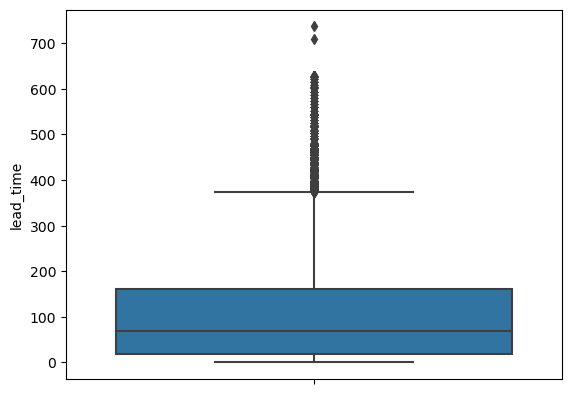

In [97]:
sns.boxplot(data=X_train, y="lead_time")


### Regra n-Sigma: 68-95-99

A regra 68-95-99 de limpeza é calcada na forma da distribuição normal: 99% dos dados estão a menos de 3 desvios padrões da média. Muitas vezes, filtramos outliers utilizando o intervalo de 2-sigmas, descartando 5% das observações com valores mais extremos.

A regra `n-Sigma` é ótima se nossa variável é **simétrica**, ou seja, se a variação para cima da média é semelhante a variação para baixo da média. Caso contrário, podemos descartar muitos dados em um eixo só: por exemplo removendo estes 5% só da parte superior da distribuição.

In [98]:
mu_lead_time = X_train["lead_time"].mean()
sig_lead_time = X_train["lead_time"].std()


In [99]:
mu_lead_time

103.94888432244086

In [100]:
sig_lead_time

106.68230648921232

In [105]:
mask_95 = (X_train["lead_time"] > (mu_lead_time - 2 * sig_lead_time)) & (
    X_train["lead_time"] < (mu_lead_time + 2 * sig_lead_time)
)
print(mask_95.sum() / X_train.shape[0])


0.9496102387706328


<Axes: xlabel='out_2sig', ylabel='lead_time'>

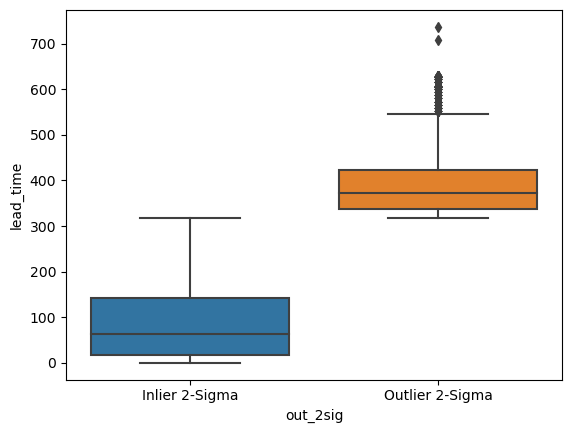

In [106]:
X_train.loc[mask_95, "out_2sig"] = "Inlier 2-Sigma"
X_train.loc[~mask_95, "out_2sig"] = "Outlier 2-Sigma"
sns.boxplot(data=X_train, x="out_2sig", y="lead_time")


Qual o problema com a exclusão acima?

#### Desigualdade de Chebyshev

A desigualdade de Chebyshev é uma extensão da regra n-Sigma para **qualquer distribuição comum (simétrica ou assimétrica)**: ela nos garante que 96% dos dados estarão à 5 desvios padrões da média.

Essa estimativa é extremamente conservadora - o que faz com que exclusão de outliers seja suave. Esta é uma regra **que sempre podemos aplicar sobre variáveis numéricas!**

In [107]:
mask_cheby = (X_train["lead_time"] > (mu_lead_time - 5 * sig_lead_time)) & (
    X_train["lead_time"] < (mu_lead_time + 5 * sig_lead_time)
)
print(mask_cheby.sum() / X_train.shape[0])


0.9999776641129302


In [109]:
mask_cheby.sum() - X_train.shape[0]

-2

<Axes: xlabel='out_cheby', ylabel='lead_time'>

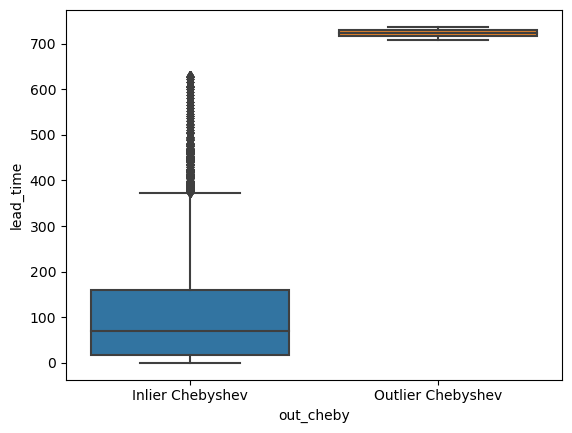

In [110]:
X_train.loc[mask_cheby, "out_cheby"] = "Inlier Chebyshev"
X_train.loc[~mask_cheby, "out_cheby"] = "Outlier Chebyshev"
sns.boxplot(data=X_train, x="out_cheby", y="lead_time")


### Utilizando a IQR

Podemos utilizar a distância interquartil para estimar thresholds de outliers assimétricos. A regra IQR funciona como um meio termo robusto entre a desigualdade de Chebyshev e a regra n-Sigma.

Como esta regra utiliza os *quantis* de uma variável, devemos tomar cuidado com variáveis extremamente concentradas (algo comum em variáveis de contagem por exemplo): nesses cassos muitas vezes o terceiro quartil é igual ao primeiro quartil - levando à uma exclusão de toda variação presente na variável.

In [111]:
q25 = np.quantile(X_train["lead_time"], 0.25)
q75 = np.quantile(X_train["lead_time"], 0.75)
iqr = q75 - q25

In [112]:
iqr

142.0

In [113]:
mask_iqr = (X_train["lead_time"] > (q25 - 1.5 * iqr)) & (
    X_train["lead_time"] < (q75 + 1.5 * iqr)
)
print(mask_iqr.sum() / X_train.shape[0])


0.9748386232159211


<Axes: xlabel='out_iqr', ylabel='lead_time'>

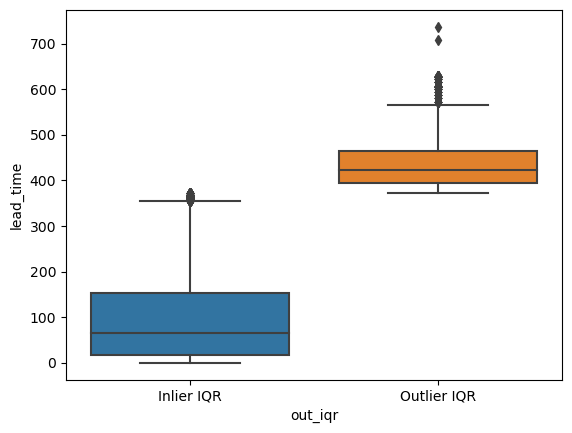

In [114]:
X_train.loc[mask_iqr, "out_iqr"] = "Inlier IQR"
X_train.loc[~mask_iqr, "out_iqr"] = "Outlier IQR"
sns.boxplot(data=X_train, x="out_iqr", y="lead_time")


## Criando normalizador

In [115]:
from sklearn.preprocessing import StandardScaler

In [116]:
num_var = ['lead_time', 'adults', 'children_imp', 'num_meal', 'adr']

In [117]:
scaler = StandardScaler()
scaler.fit(X_train[num_var])

StandardScaler()

In [118]:
scaler.get_feature_names_out()

array(['lead_time', 'adults', 'children_imp', 'num_meal', 'adr'],
      dtype=object)

# Construindo nossos conjuntos de treinamento e teste

1. Podemos alterar o número de linhas **APENAS** no **conjunto de treinamento**;
    * *Isso inclui qualquer operação de limpeza de NAs e outliers.*
1. Qualquer etapa de **aprendizagem** pode ser executada apenas no **conjunto de treinamento**;
    * *Isso inclui encoders (ordinais e OH), imputadores, normalizadores e agrupamento de valores categóricos.*
1. Toda transformação deve ser realizada **tanto no conjunto de teste quanto no conjunto final**.

## Finalizando nosso dataset de treinamento

Vamos consolidar todas as etapas construídas acima.

### Máscaras de Outliers

In [119]:
mu_adults = X_train["adults"].mean()
sig_adults = X_train["adults"].std()
mask_cheby_adults = (X_train["adults"] > (mu_adults - 5 * sig_adults)) & (
    X_train["adults"] < (mu_adults + 5 * sig_adults)
)

In [120]:
mu_child = X_train["children_imp"].mean()
sig_child = X_train["children_imp"].std()
mask_cheby_child = (X_train["children_imp"] > (mu_child - 5 * sig_child)) & (
    X_train["children_imp"] < (mu_child + 5 * sig_child)
)

In [124]:
mu_child = X_train["adr"].mean()
sig_child = X_train["adr"].std()
mask_cheby_adr = (X_train["adr"] > (mu_child - 2 * sig_child)) & (
    X_train["adr"] < (mu_child + 2 * sig_child)
)

In [122]:
q25 = np.quantile(X_train["lead_time"], 0.25)
q75 = np.quantile(X_train["lead_time"], 0.75)
iqr = q75 - q25
mask_iqr_lead_time = (X_train["lead_time"] > (q25 - 1.5 * iqr)) & (
    X_train["lead_time"] < (q75 + 1.5 * iqr)
)

Vamos remover os outliers da nossa base de **treinamento**:

In [123]:
mask_inliner = (mask_iqr_lead_time) & (mask_cheby_child) & (mask_cheby_adults)
print(f"Removendo {np.round(100*(1-mask_inliner.sum()/X_train.shape[0]), 2)}% do Train-set")

Removendo 6.34% do Train-set


In [125]:
X_train_nout = X_train.loc[mask_inliner]

In [126]:
X_train_nout

,lead_time,adults,meal,adr,is_company,children_imp,country_grp,num_meal,out_2sig,out_cheby,out_iqr
118613,297,2,BB,39.67,0.0,1.0,PRT,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
96963,176,2,BB,125.10,0.0,0.0,ITA,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
47315,71,2,BB,78.30,0.0,0.0,GBR,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
88591,115,2,BB,99.45,0.0,0.0,DEU,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
93853,0,2,BB,159.00,0.0,0.0,PRT,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
...,...,...,...,...,...,...,...,...,...,...,...
111693,128,2,BB,193.50,0.0,0.0,IRL,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
29840,28,2,BB,32.31,0.0,0.0,GBR,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
75279,299,2,BB,62.00,0.0,0.0,PRT,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR
4992,66,2,BB,68.00,0.0,0.0,PRT,2.0,Inlier 2-Sigma,Inlier Chebyshev,Inlier IQR


### Aplicando transformações

In [127]:
X_train_numerical = X_train_nout[num_var]
X_sca = pd.DataFrame(
    scaler.transform(X_train_numerical),
    columns = scaler.get_feature_names_out(),
    index = X_train_nout.index
)
X_sca

,lead_time,adults,children_imp,num_meal,adr
118613,1.809599,0.236906,2.240396,-0.05136,-1.212627
96963,0.675384,0.236906,-0.261126,-0.05136,0.450767
47315,-0.308852,0.236906,-0.261126,-0.05136,-0.460468
88591,0.103590,0.236906,-0.261126,-0.05136,-0.048660
93853,-0.974383,0.236906,-0.261126,-0.05136,1.110829
...,...,...,...,...,...
111693,0.225447,0.236906,-0.261126,-0.05136,1.782572
29840,-0.711920,0.236906,-0.261126,-0.05136,-1.355932
75279,1.828346,0.236906,-0.261126,-0.05136,-0.777843
4992,-0.355721,0.236906,-0.261126,-0.05136,-0.661018


In [128]:
X_dum = pd.DataFrame(
    ohe.transform(X_train_nout[ohe_vars]),
    columns = ohe.get_feature_names_out(),
    index = X_train_nout.index
)
X_dum['is_company'] = X_train_nout['is_company']
X_dum.head()

,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,country_grp_ESP,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA,is_company
118613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88591,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [129]:
X_train_final = pd.concat([X_sca, X_dum], axis = 1)
X_train_final.head()

,lead_time,adults,children_imp,num_meal,adr,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,country_grp_ESP,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA,is_company
118613,1.809599,0.236906,2.240396,-0.05136,-1.212627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96963,0.675384,0.236906,-0.261126,-0.05136,0.450767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47315,-0.308852,0.236906,-0.261126,-0.05136,-0.460468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88591,0.103590,0.236906,-0.261126,-0.05136,-0.048660,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93853,-0.974383,0.236906,-0.261126,-0.05136,1.110829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Finalizando nosso dataset de test

Agora vamos replicar as transformações no nosso conjunto de teste.

### Tratativas de NA

Primeiro, trataremos manualmente a coluna `company`:

In [130]:
mask_na_company = X_test["company"].isna()
X_test.loc[mask_na_company, "is_company"] = 0
X_test.loc[~mask_na_company, "is_company"] = 1

Agora, vamos aplicar nossos imputadores:

In [132]:
X_test['country_imp'] = country_imputer.transform(X_test[["country"]]).ravel()
X_test['children_imp'] = children_imputer.transform(X_test[["children"]]).ravel()

In [133]:
X_test

,lead_time,country,company,children,adults,meal,adr,is_company,country_imp,children_imp
9175,70,IRL,NaN,0.0,2,BB,37.80,0.0,IRL,0.0
5253,83,PRT,NaN,0.0,2,BB,70.00,0.0,PRT,0.0
66562,99,ITA,NaN,0.0,3,BB,172.80,0.0,ITA,0.0
37030,56,DEU,NaN,0.0,2,BB,122.57,0.0,DEU,0.0
85621,17,PRT,NaN,0.0,2,BB,80.00,0.0,PRT,0.0
...,...,...,...,...,...,...,...,...,...,...
84093,99,PRT,67.0,0.0,1,BB,80.00,1.0,PRT,0.0
56318,133,ITA,NaN,0.0,2,SC,118.80,0.0,ITA,0.0
39600,4,ESP,NaN,0.0,2,BB,253.00,0.0,ESP,0.0
5351,189,PRT,NaN,0.0,2,BB,46.00,0.0,PRT,0.0


### Variáveis categóricas

Vamos começar tratando a coluna `country`:

In [134]:
X_test['country_grp'] = X_test['country_imp'].map(dict_country)

e agora a coluna `meal`

In [135]:
X_test['num_meal'] = ordinal.transform(X_test[["meal"]])

In [136]:
X_test

,lead_time,country,company,children,adults,meal,adr,is_company,country_imp,children_imp,country_grp,num_meal
9175,70,IRL,NaN,0.0,2,BB,37.80,0.0,IRL,0.0,IRL,2.0
5253,83,PRT,NaN,0.0,2,BB,70.00,0.0,PRT,0.0,PRT,2.0
66562,99,ITA,NaN,0.0,3,BB,172.80,0.0,ITA,0.0,ITA,2.0
37030,56,DEU,NaN,0.0,2,BB,122.57,0.0,DEU,0.0,DEU,2.0
85621,17,PRT,NaN,0.0,2,BB,80.00,0.0,PRT,0.0,PRT,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
84093,99,PRT,67.0,0.0,1,BB,80.00,1.0,PRT,0.0,PRT,2.0
56318,133,ITA,NaN,0.0,2,SC,118.80,0.0,ITA,0.0,ITA,1.0
39600,4,ESP,NaN,0.0,2,BB,253.00,0.0,ESP,0.0,ESP,2.0
5351,189,PRT,NaN,0.0,2,BB,46.00,0.0,PRT,0.0,PRT,2.0


### Finalizando com scalers e encoders

In [137]:
X_test_numerical = X_test.loc[:, num_var]
X_sca_test = pd.DataFrame(
    scaler.transform(X_test_numerical),
    columns = scaler.get_feature_names_out(),
    index = X_test_numerical.index
)

In [138]:
X_dum_test = pd.DataFrame(
    ohe.transform(X_test[ohe_vars]),
    columns = ohe.get_feature_names_out(),
    index = X_test.index
)
X_dum_test['is_company'] = X_test['is_company']

/Users/pedroteche/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [139]:
X_test_final = pd.concat([X_sca_test, X_dum_test], axis = 1)
X_test_final.head()

,lead_time,adults,children_imp,num_meal,adr,country_grp_BEL,country_grp_BRA,country_grp_CHE,country_grp_CN,country_grp_DEU,country_grp_ESP,country_grp_FRA,country_grp_GBR,country_grp_IRL,country_grp_ITA,country_grp_NLD,country_grp_Others,country_grp_PRT,country_grp_USA,is_company
9175,-0.318226,0.236906,-0.261126,-0.05136,-1.249037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5253,-0.196368,0.236906,-0.261126,-0.05136,-0.622076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
66562,-0.046389,1.905517,-0.261126,-0.05136,1.379526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
37030,-0.449457,0.236906,-0.261126,-0.05136,0.401506,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85621,-0.815031,0.236906,-0.261126,-0.05136,-0.427368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Voltamos 21h50